##Comparison between tracer transport and water transport through shelf break

This notebook explores the similarities and differences between total tracer transport and total transport across (normal to) the shelf break wall<sup>1</sup>. Total Tracer Transport (TracTrans) is understood here as tracer transport (concentration * transport) per cell area; similarly, Total Transport (Trans) is transport per cell area, which is only the speed. This gives the following units:

$[TracTrans] = [C]ms^{-1} $

$[Trans] = [v] = ms^{-1} $

The idea is to compare this two quatities in space and time. Also, we can compare the velocity to the contribution to tracer transport of advection and diffusion individually, since

TracTrans = AdvFlux + DiffFlux / cell area

<sup>1</sup> Plane that goes from shelf-break depth to surface and all along the shelf break

In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

from math import *

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns

In [2]:
lib_path = os.path.abspath('../../Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 

import ShelfBreakTools_MITgcm as sb

import savitzky_golay as sg

In [3]:
CanyonGrid='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)
#for dimobj in CanyonGridOut.variables.values():
#    print dimobj

CanyonState='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

FluxTR01 = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run01/FluxTR01Glob.nc'
FluxOut = Dataset(FluxTR01)

CanyonGridNoC='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run02/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonStateNoC='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run02/stateGlob.nc'

FluxTR01NoC = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run02/FluxTR01Glob.nc'


In [4]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

z = CanyonStateOut.variables['Z']
#print(z[10])
Time = CanyonStateOut.variables['T']
#print(Time[:])

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells

yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

dxF = rout.getField(CanyonGrid, 'dxF')
drF = CanyonGridOut.variables['drF']

In [5]:
sns.set()
sns.set_style('white')
sns.set_context('notebook')

### TracTrans vs Vel

In [6]:
V = rout.getField(CanyonState,'V') # 
VNoC = rout.getField(CanyonStateNoC,'V') # 
VTRAC01NoC = rout.getField(FluxTR01NoC,'VTRAC01') # 
VTRAC01 = rout.getField(FluxTR01,'VTRAC01') # 

U = rout.getField(CanyonState,'U') # 
UNoC = rout.getField(CanyonStateNoC,'U') # 
UTRAC01NoC = rout.getField(FluxTR01NoC,'UTRAC01') # 
UTRAC01 = rout.getField(FluxTR01,'UTRAC01') # 


In [7]:
zlev = 29
SBx, SBy = sb.findShelfBreak(zlev,hFacC)
SBxx = SBx[:-1]
SByy = SBy[:-1]
slope, theta = sb.findSlope(xc,yc,SBxx,SByy)
slopeFilt = sg.savitzky_golay(slope, 11, 3) # window size 11, polynomial order 3
thetaFilt = np.arctan(slopeFilt)




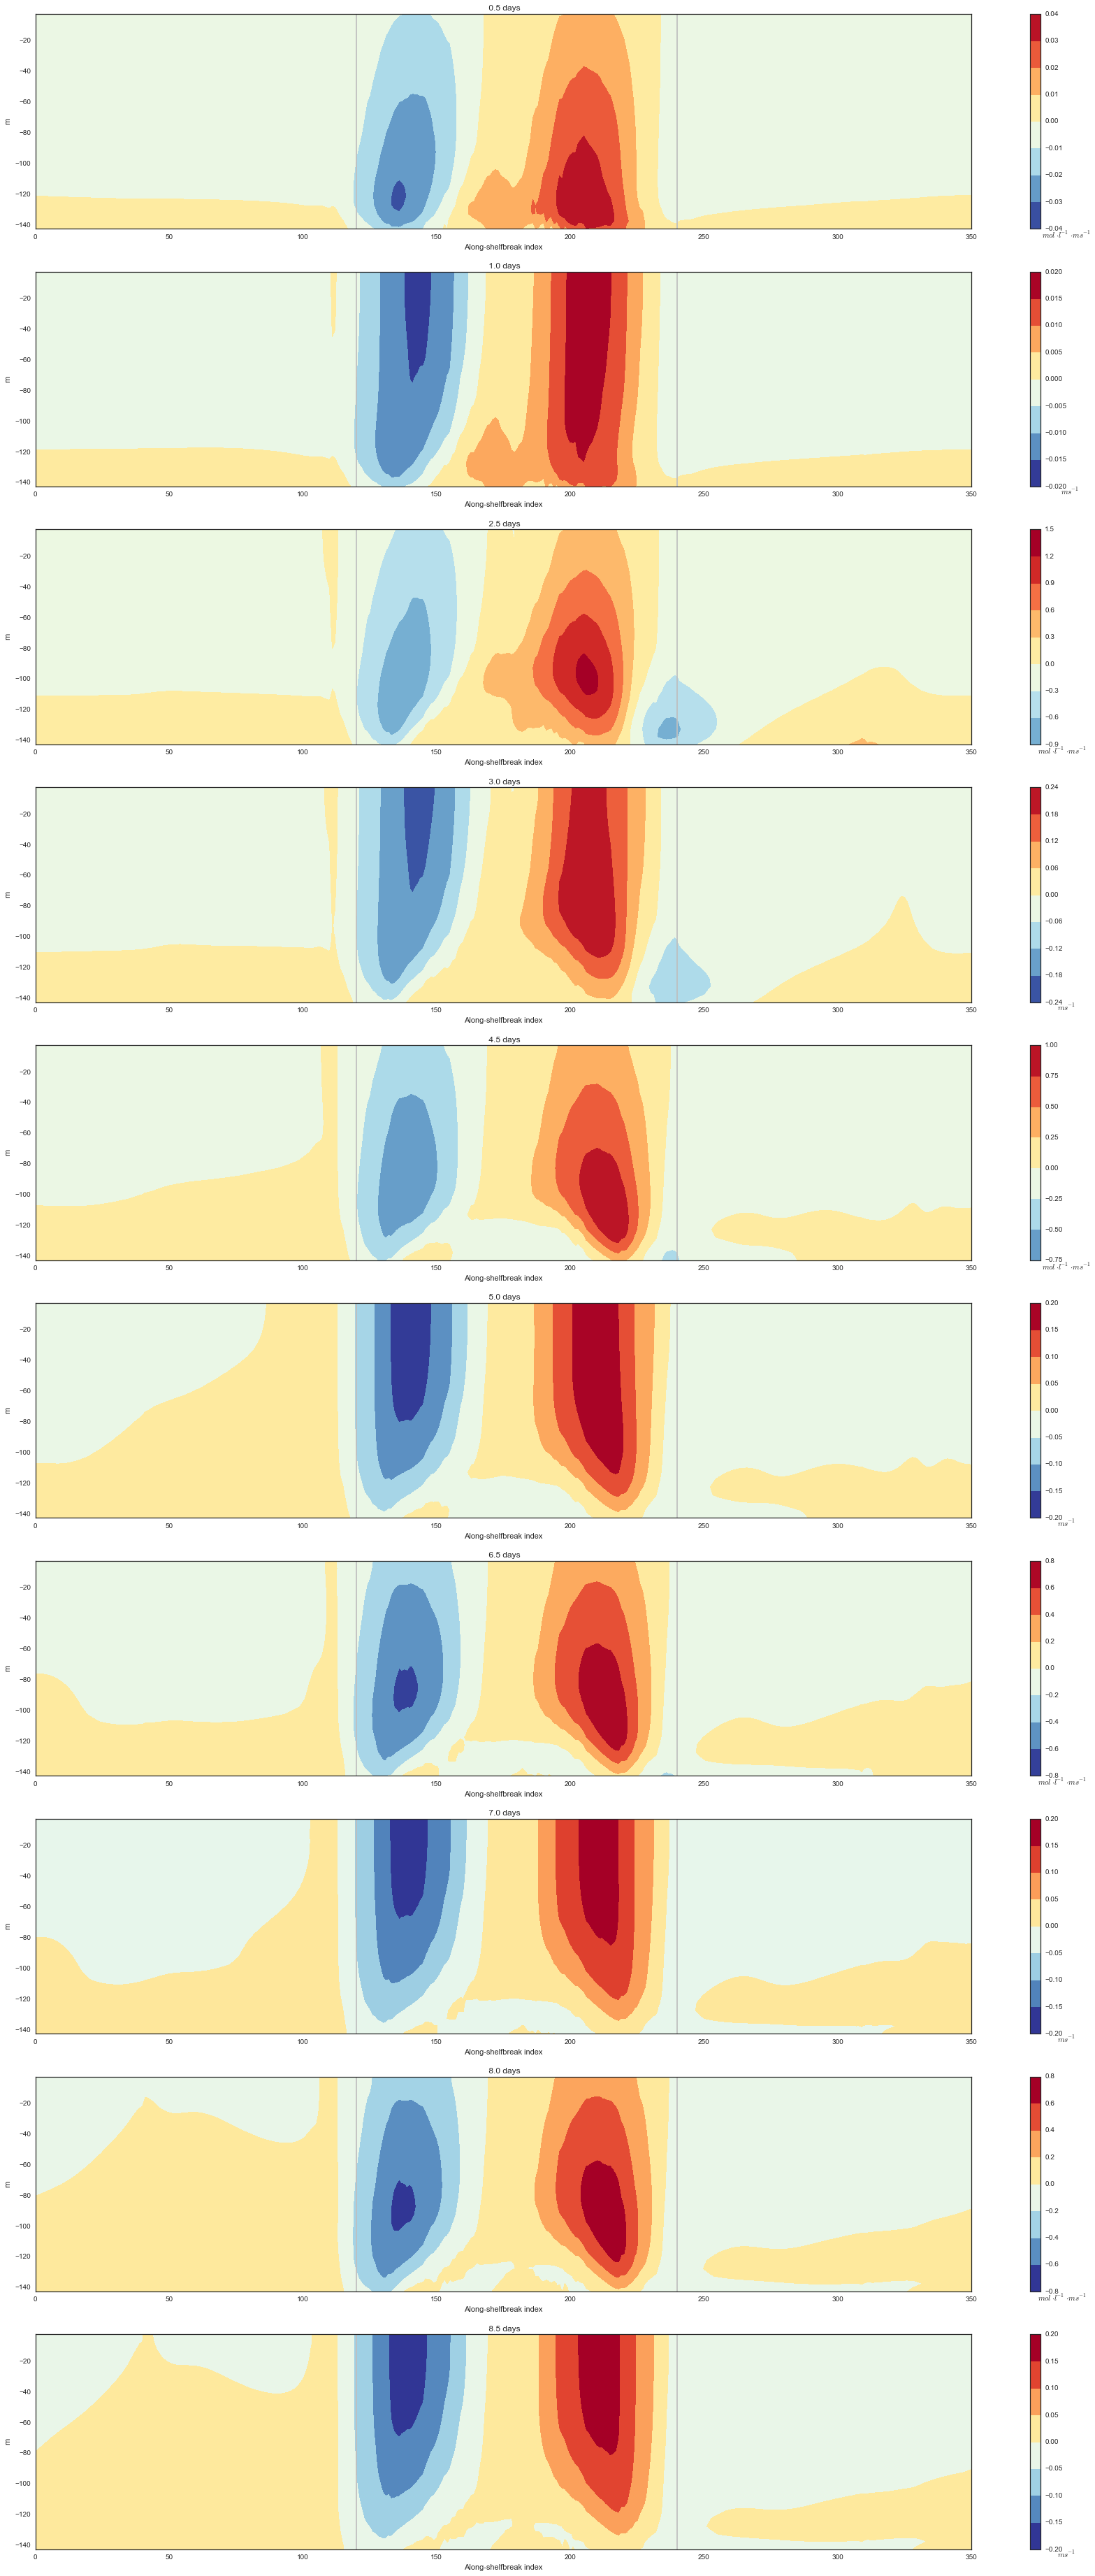

In [8]:
times = [0,4,8,12,15] # First time element of flux is at 43200 sec, and las at 8 days 
times2 = [1,5,9,13,16]
figSize=(30,65)
numCols = 1
numRows = 10
zlev = 29
unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'
unitsVel = '$ms^{-1}$'

kk=1

fig44 = plt.figure(figsize=figSize)

for tt in zip(times,times2):
    
    VTRACPlot = sb.MerFluxSB(SBxx,SByy,tt[0],VTRAC01,z,xc,zlev,hFacC,MaskC)
    UTRACPlot = sb.ZonFluxSB(SBxx,SByy,tt[0],UTRAC01,z,xc,zlev,hFacC,MaskC)
    
    VPlot = sb.MerFluxSB(SBxx,SByy,tt[1],V,z,xc,zlev,hFacC,MaskC)
    UPlot = sb.ZonFluxSB(SBxx,SByy,tt[1],U,z,xc,zlev,hFacC,MaskC)
    
    TracTrans =  VTRACPlot[:,4:-5]*np.cos(thetaFilt) + UTRACPlot[:,4:-4]*np.sin(-thetaFilt) 
    NormalVel =  VPlot[:,4:-5]*np.cos(thetaFilt) + UPlot[:,4:-4]*np.sin(-thetaFilt) 

    sb.contourfFluxSB(tt[0],numCols,numRows,TracTrans,z,xc,unitsTr, 0,29,kk,zlev)
    sb.contourfFluxSB(tt[1],numCols,numRows,NormalVel,z,xc,unitsVel, 0,29,kk+1,zlev)
    
    kk = kk+2

    
   

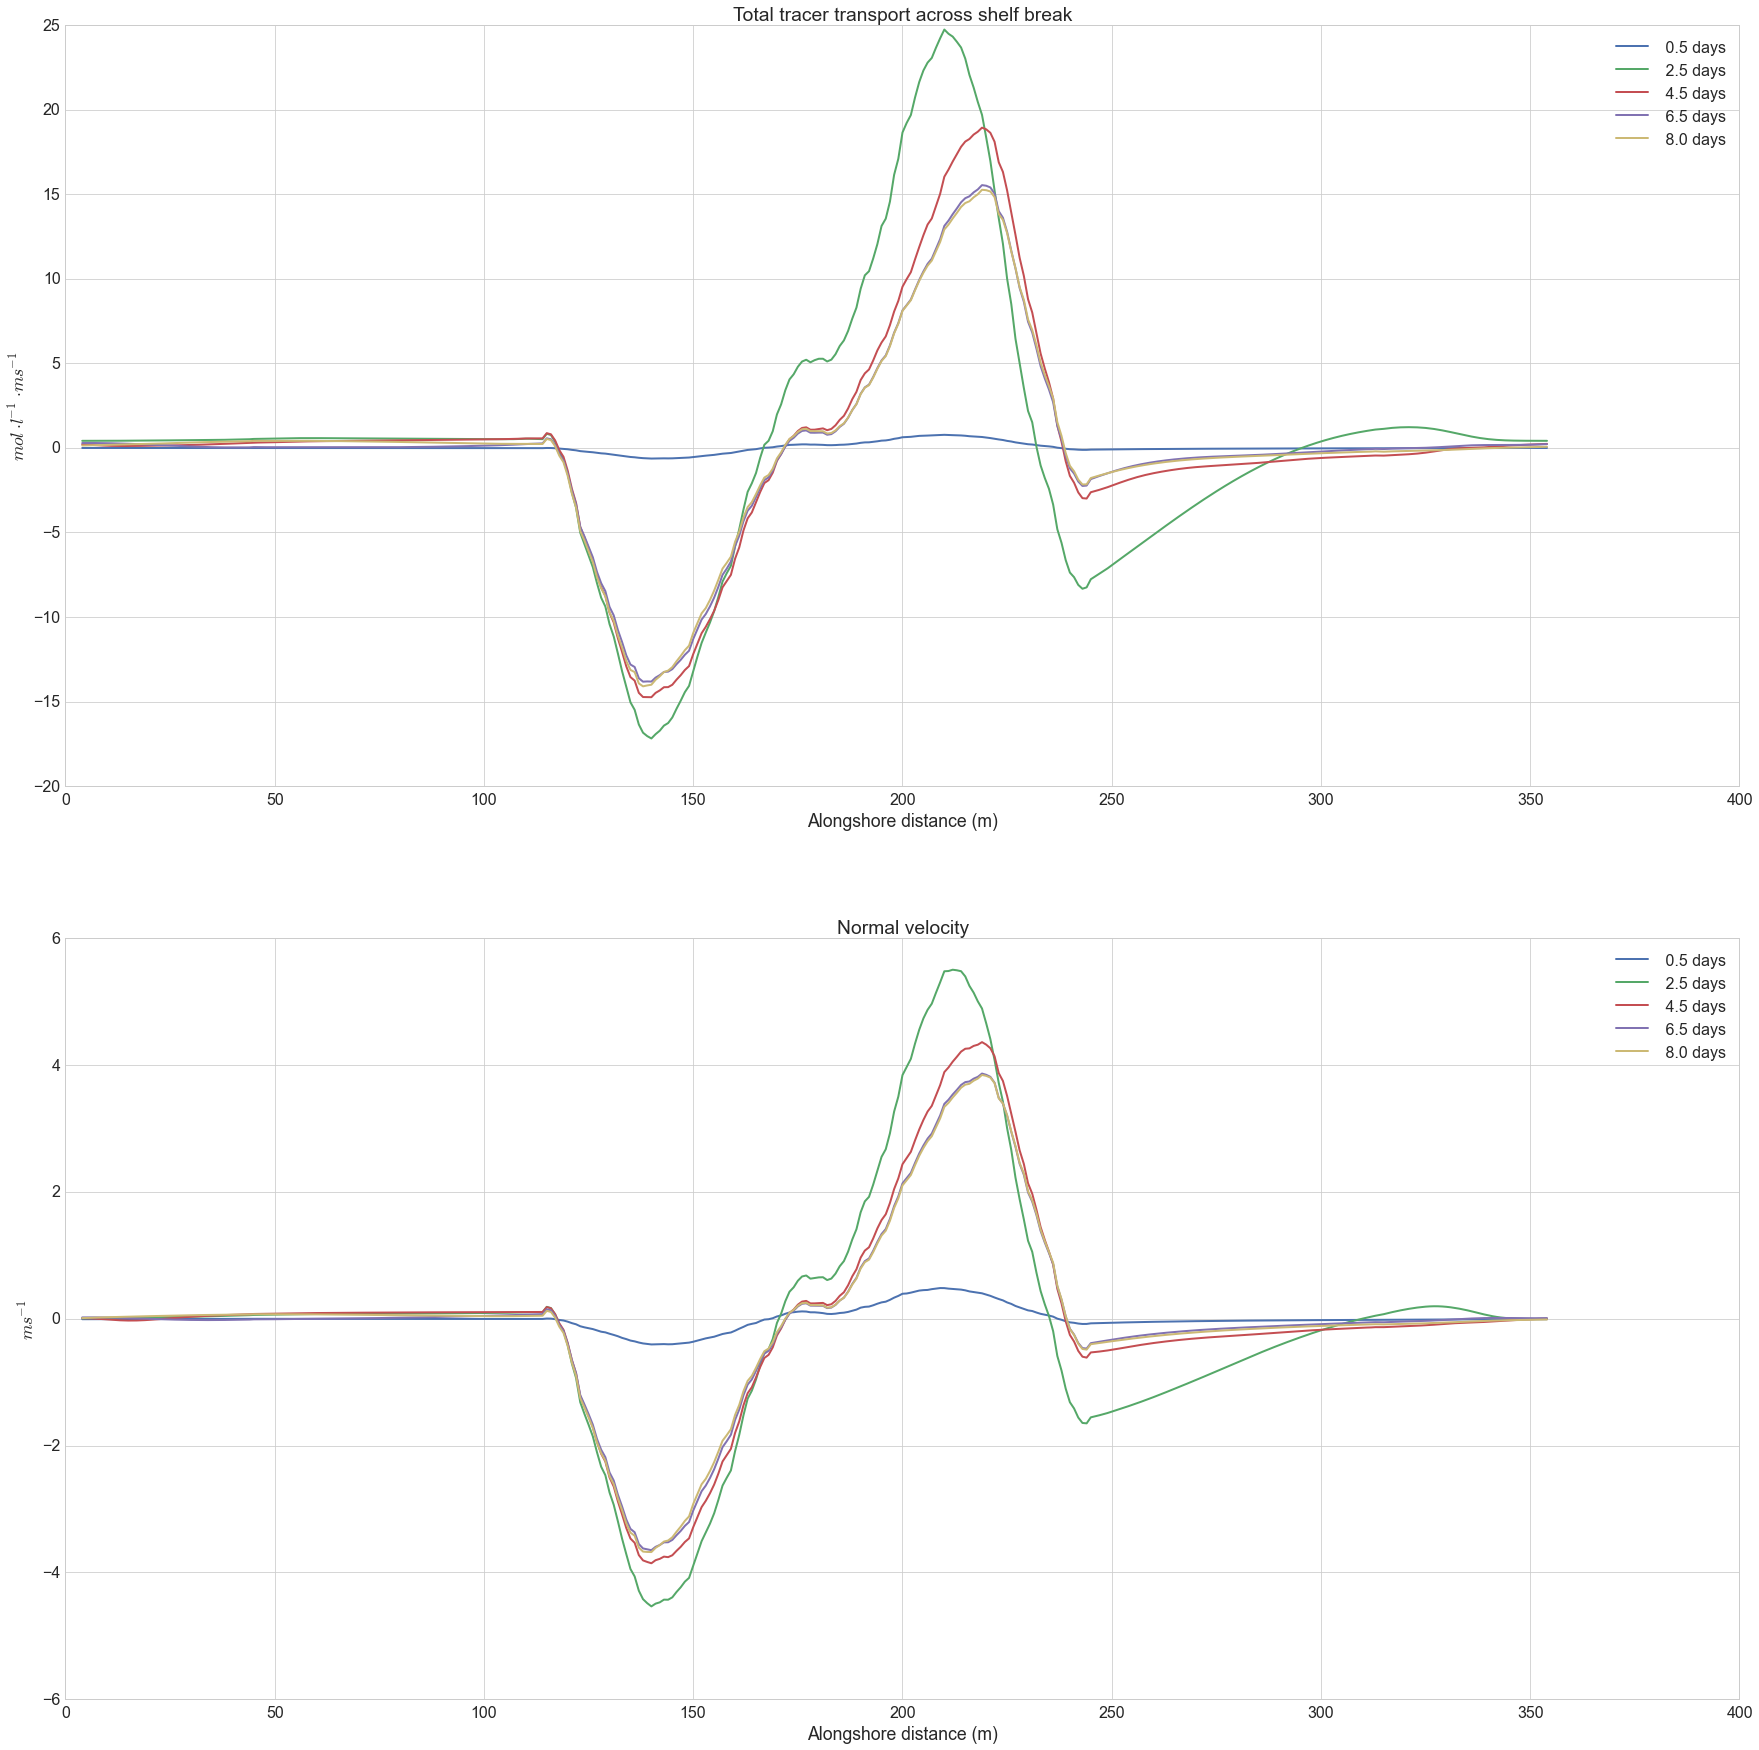

In [9]:
sns.set(context='paper', style='whitegrid', font='sans-serif', font_scale=2, rc={"lines.linewidth": 2.5})
times = [0,4,8,12,15] # First time element of flux is at 43200 sec, and las at 8 days 
times2 = [1,5,9,13,16]
figSize=(30,30)
numCols = 1
numRows = 2
zlev = 29
unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'
unitsVel = '$ms^{-1}$'

kk=1

fig44 = plt.figure(figsize=figSize)

for tt in zip(times,times2):
    VTRACPlot = sb.MerFluxSB(SBxx,SByy,tt[0],VTRAC01,z,xc,zlev,hFacC,MaskC)
    UTRACPlot = sb.ZonFluxSB(SBxx,SByy,tt[0],UTRAC01,z,xc,zlev,hFacC,MaskC)
    TracTrans =  VTRACPlot[:,4:-5]*np.cos(thetaFilt) + UTRACPlot[:,4:-4]*np.sin(-thetaFilt) 
    plt.subplot(numRows,numCols,1)
    ax = plt.gca()
    ax.plot(np.arange(4,360-5,1),np.sum(TracTrans,axis=0),linewidth=2,label = (" %1.1f days " % ((tt[0]/2.)+0.5)))
    plt.legend(loc=0)
    plt.xlabel('Alongshore distance (m)')
    plt.ylabel(unitsTr)
    plt.title('Total tracer transport across shelf break')
    
    VPlot = sb.MerFluxSB(SBxx,SByy,tt[1],V,z,xc,zlev,hFacC,MaskC)
    UPlot = sb.ZonFluxSB(SBxx,SByy,tt[1],U,z,xc,zlev,hFacC,MaskC)
    NormalVel =  VPlot[:,4:-5]*np.cos(thetaFilt) + UPlot[:,4:-4]*np.sin(-thetaFilt) 
    plt.subplot(numRows,numCols,2)
    ax = plt.gca()
    ax.plot(np.arange(4,360-5,1),np.sum(NormalVel,axis=0),linewidth=2,label = (" %1.1f days " % ((tt[0]/2.)+0.5)))
    plt.legend(loc=0)
    plt.xlabel('Alongshore distance (m)')
    plt.ylabel(unitsVel)
    plt.title('Normal velocity')
    
    

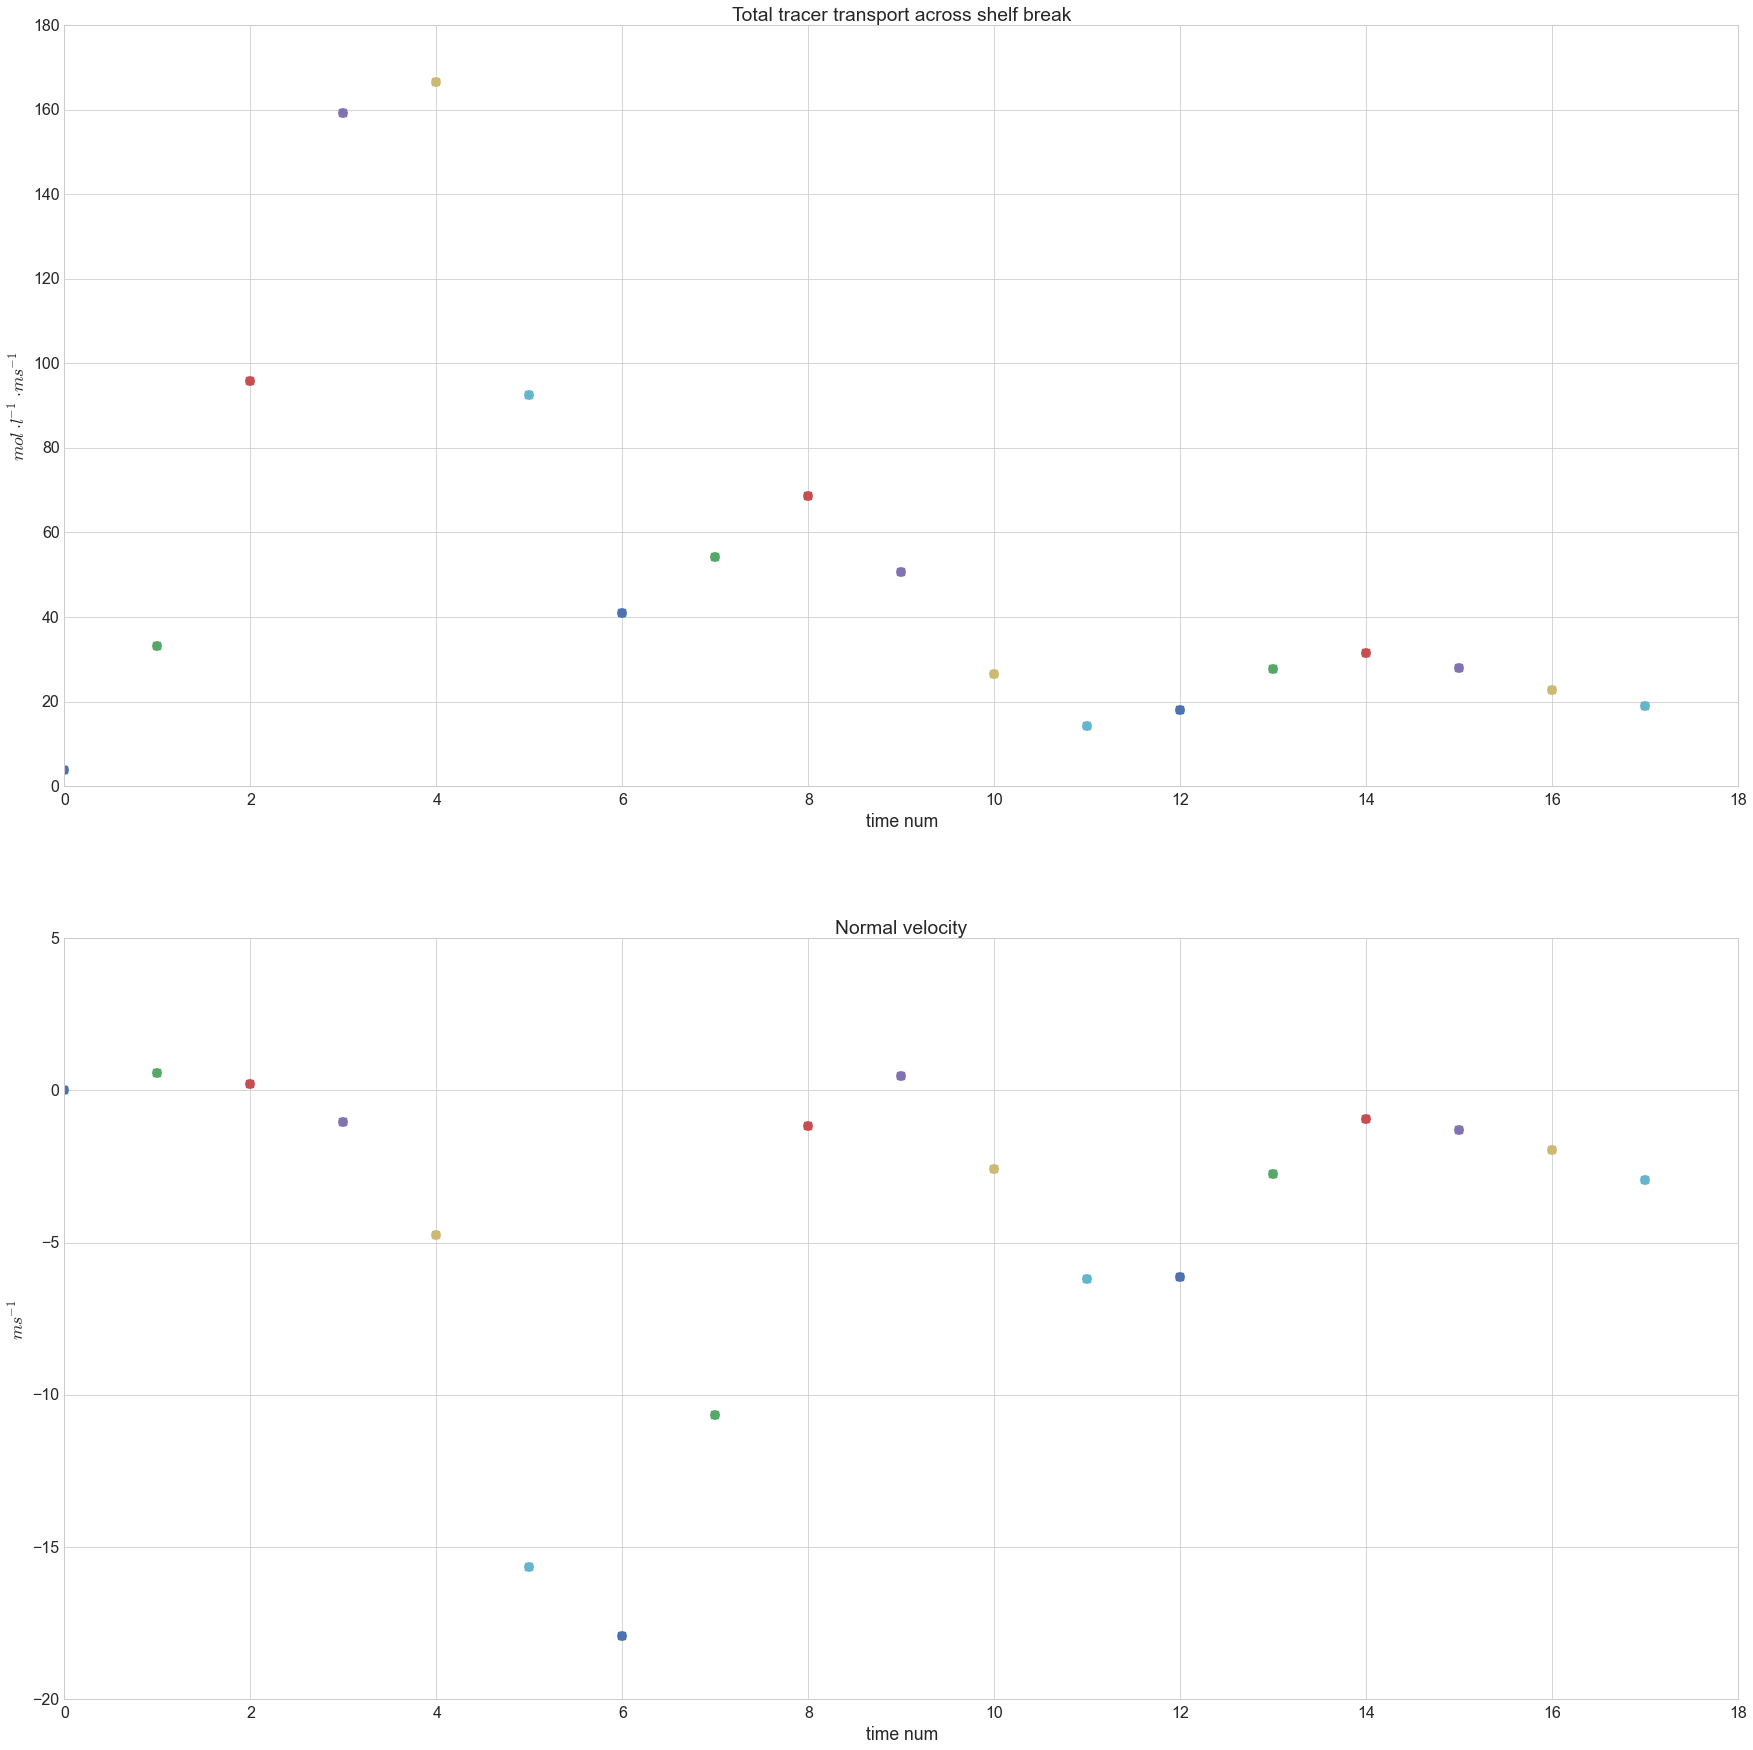

In [10]:
sns.set(context='paper', style='whitegrid', font='sans-serif', font_scale=2, rc={"lines.linewidth": 2.5})
times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times2 = range(18)
figSize=(30,30)
numCols = 1
numRows = 2
zlev = 29
unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'
unitsVel = '$ms^{-1}$'

kk=1

fig44 = plt.figure(figsize=figSize)

for tt in times:
    VTRACPlot = sb.MerFluxSB(SBxx,SByy,tt,VTRAC01,z,xc,zlev,hFacC,MaskC)
    UTRACPlot = sb.ZonFluxSB(SBxx,SByy,tt,UTRAC01,z,xc,zlev,hFacC,MaskC)
    TracTrans =  VTRACPlot[:,4:-5]*np.cos(thetaFilt) + UTRACPlot[:,4:-4]*np.sin(-thetaFilt) 
    plt.subplot(numRows,numCols,1)
    ax = plt.gca()
    ax.plot(tt,np.sum(TracTrans),'o',markersize = 10,label = (" %1.1f days " % ((tt/2.)+0.5)))
    #plt.legend(loc=0)
    plt.xlabel('time num')
    plt.ylabel(unitsTr)
    plt.title('Total tracer transport across shelf break')
    
    VPlot = sb.MerFluxSB(SBxx,SByy,tt,V,z,xc,zlev,hFacC,MaskC)
    UPlot = sb.ZonFluxSB(SBxx,SByy,tt,U,z,xc,zlev,hFacC,MaskC)
    NormalVel =  VPlot[:,4:-5]*np.cos(thetaFilt) + UPlot[:,4:-4]*np.sin(-thetaFilt) 
    plt.subplot(numRows,numCols,2)
    ax = plt.gca()
    ax.plot(tt,np.sum(NormalVel),'o',markersize = 10,label = (" %1.1f days " % ((tt/2.)+0.5)))
    #plt.legend(loc=0)
    plt.xlabel('time num')
    plt.ylabel(unitsVel)
    plt.title('Normal velocity')

<matplotlib.colorbar.Colorbar instance at 0x7f505a3ddef0>

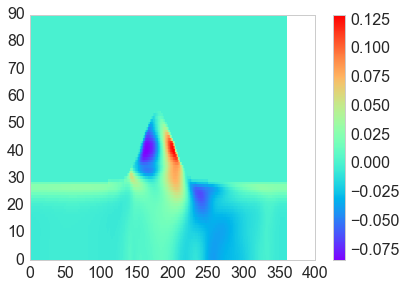

In [11]:
plt.pcolor(V[6,:,200,:],cmap='rainbow')
plt.colorbar()

<matplotlib.colorbar.Colorbar instance at 0x7f505cb061b8>

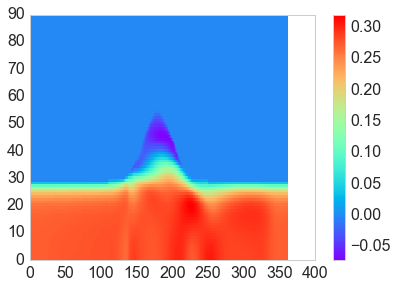

In [12]:
plt.pcolor(U[6,:,200,:],cmap='rainbow')
plt.colorbar()

###No-canyon case

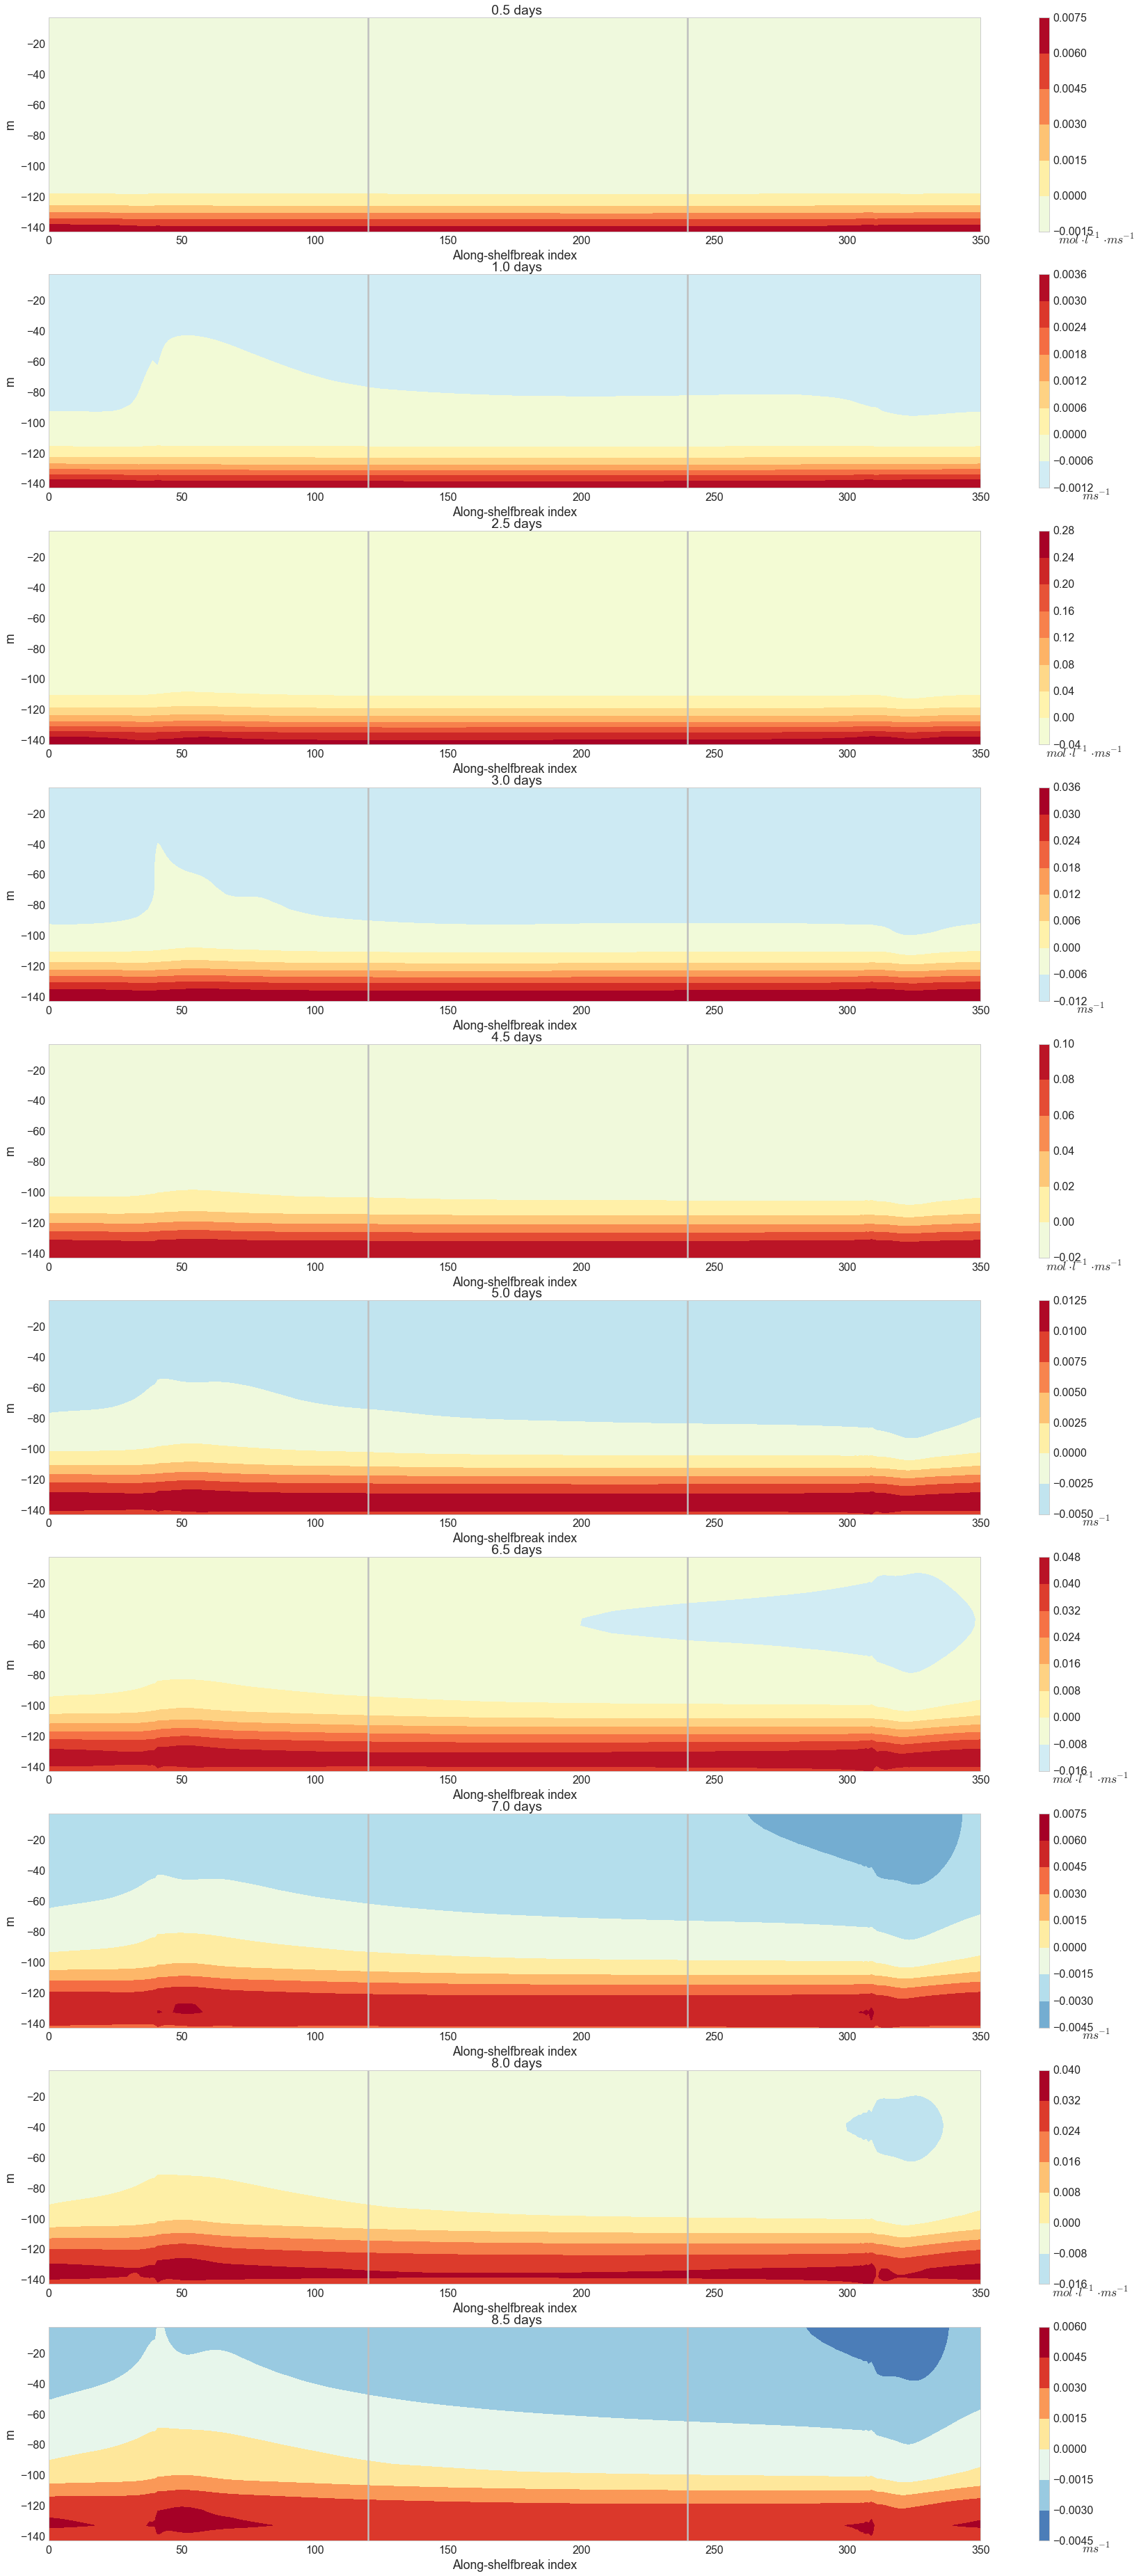

In [13]:
zlev = 29
SBxNoC, SByNoC = sb.findShelfBreak(zlev,hFacCNoC)
SBxxNoC = SBxNoC[:-1]
SByyNoC = SByNoC[:-1]
slopeNoC, thetaNoC = sb.findSlope(xc,yc,SBxxNoC,SByyNoC)
#slopeFiltNoC = sg.savitzky_golay(slopeNoC, 11, 3) # window size 11, polynomial order 3
slopeFiltNoC = slopeNoC
thetaFiltNoC = np.arctan(slopeFiltNoC)


times = [0,4,8,12,15] # First time element of flux is at 43200 sec, and las at 8 days 
times2 = [1,5,9,13,16] # First time element of flux is at 43200 sec, and las at 8 days 

figSize=(30,65)
numCols = 1
numRows = 10
zlev = 29
unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'
unitsVel = '$ms^{-1}$'

kk=1

fig44 = plt.figure(figsize=figSize)

for tt in zip(times,times2):
    
    VTRACPlot = sb.MerFluxSB(SBxxNoC,SByyNoC,tt[0],VTRAC01NoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    UTRACPlot = sb.ZonFluxSB(SBxxNoC,SByyNoC,tt[0],UTRAC01NoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    
    VPlot = sb.MerFluxSB(SBxxNoC,SByyNoC,tt[1],VNoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    UPlot = sb.ZonFluxSB(SBxxNoC,SByyNoC,tt[1],UNoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    
    TracTrans =  VTRACPlot[:,4:-5]*np.cos(thetaFiltNoC) + UTRACPlot[:,4:-4]*np.sin(-thetaFiltNoC) 
    NormalVel =  VPlot[:,4:-5]*np.cos(thetaFiltNoC) + UPlot[:,4:-4]*np.sin(-thetaFiltNoC) 

    sb.contourfFluxSB(tt[0],numCols,numRows,TracTrans,z,xc,unitsTr, 0,29,kk,zlev)
    sb.contourfFluxSB(tt[1],numCols,numRows,NormalVel,z,xc,unitsVel, 0,29,kk+1,zlev)
    
    kk = kk+2


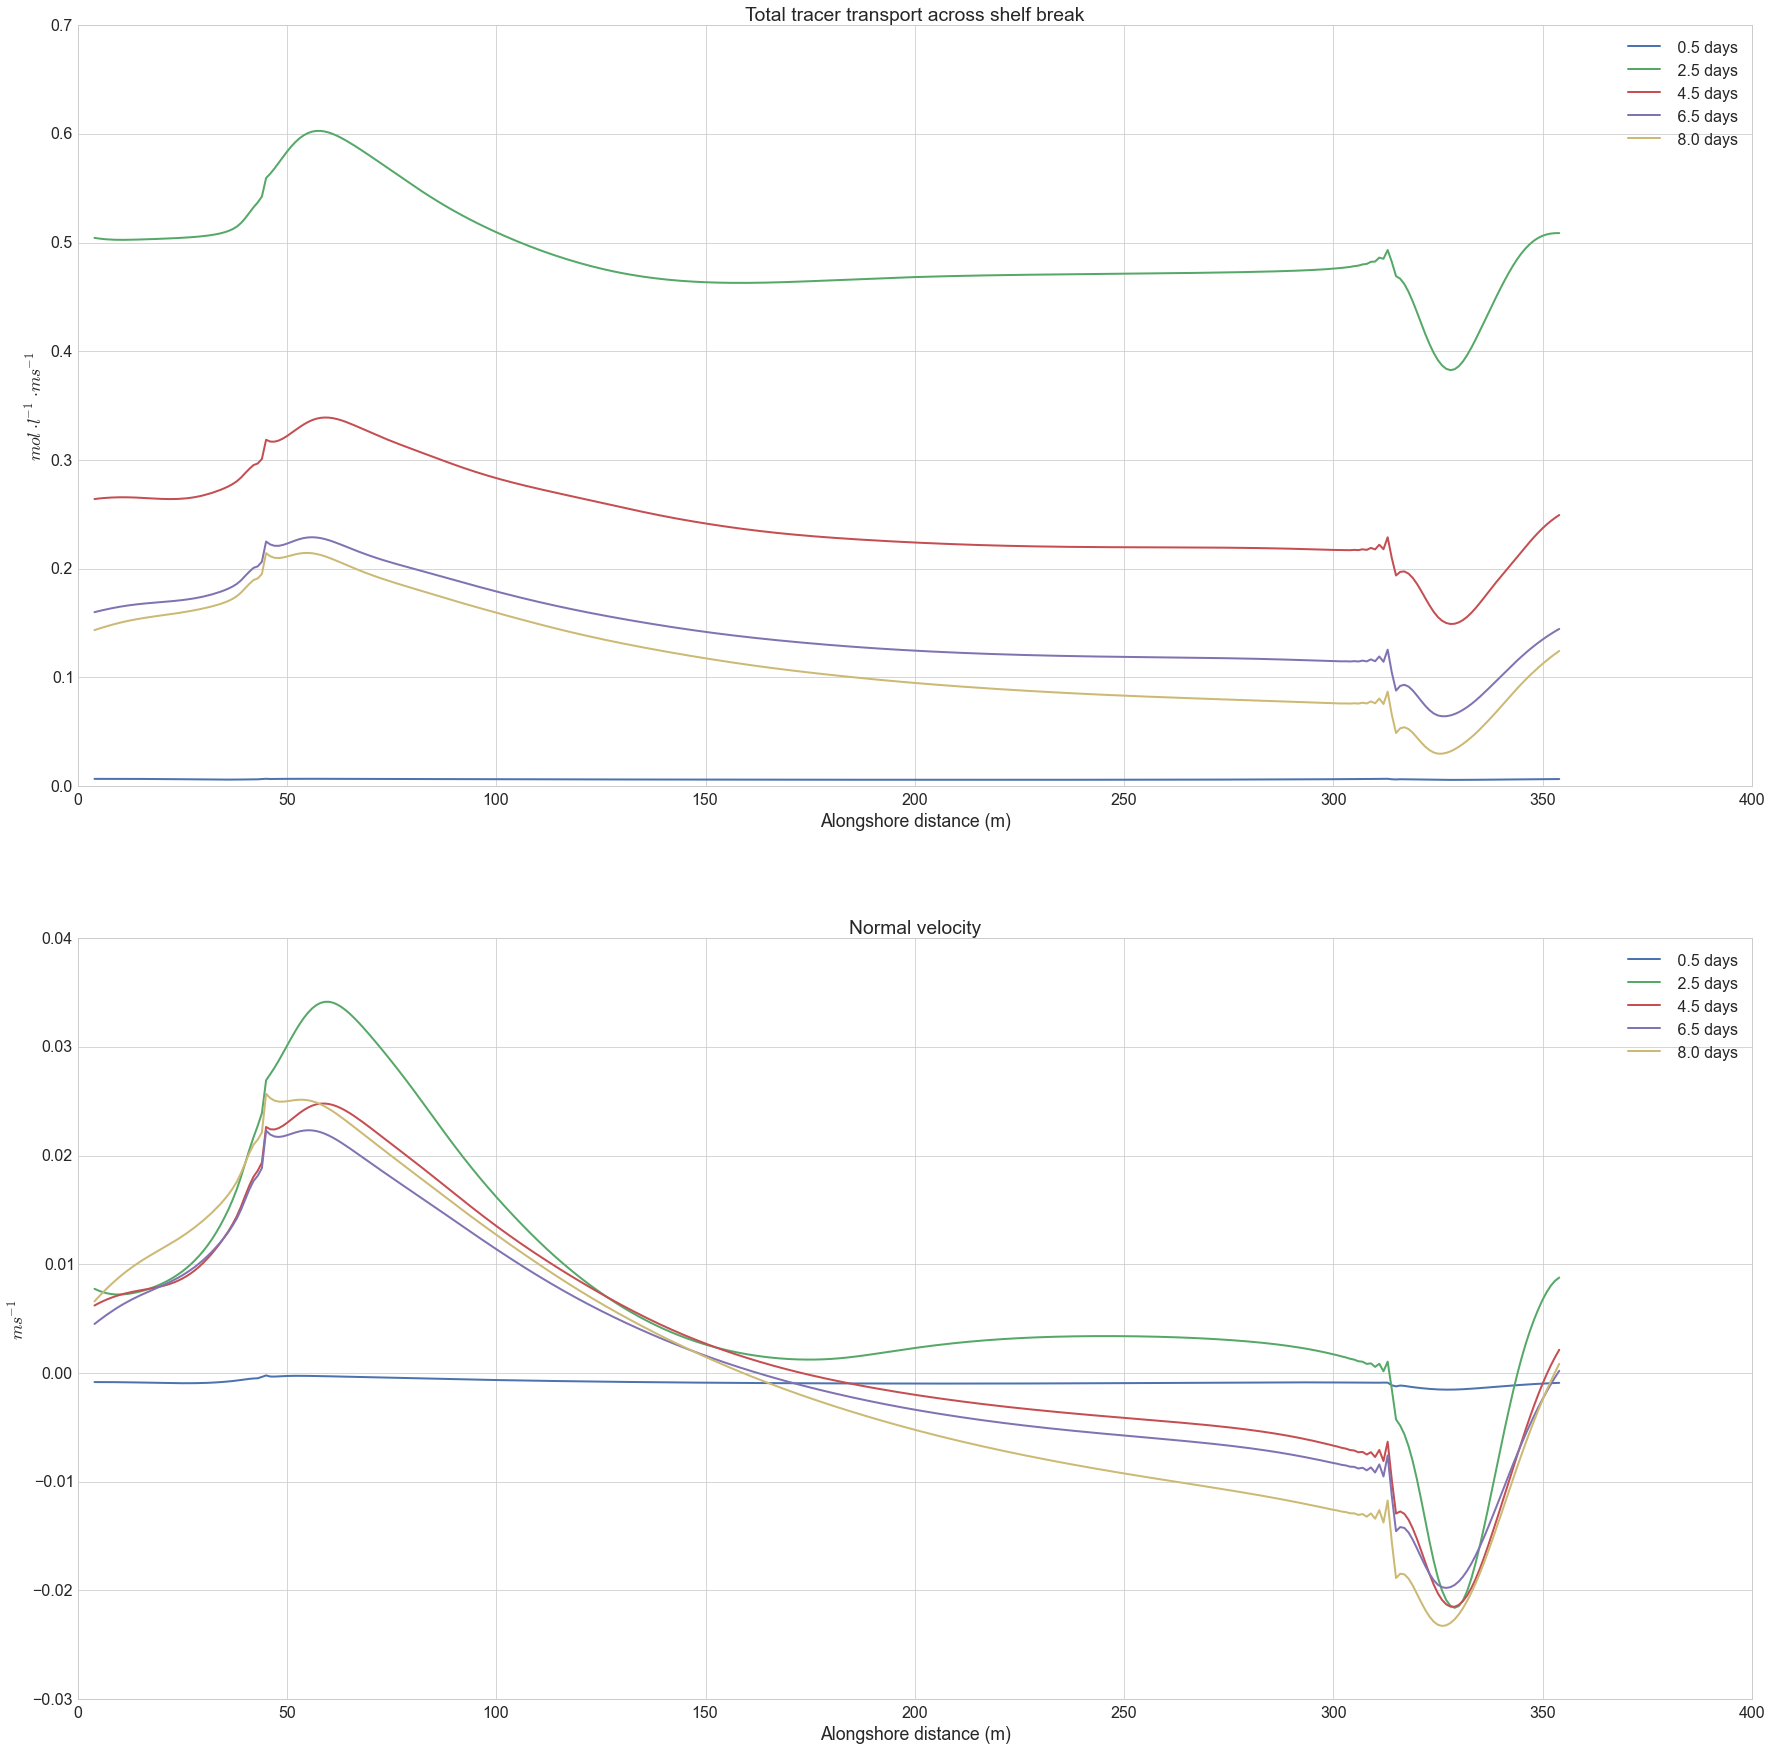

In [15]:
sns.set(context='paper', style='whitegrid', font='sans-serif', font_scale=2, rc={"lines.linewidth": 2.5})
times = [0,4,8,12,15] # First time element of flux is at 43200 sec, and las at 8 days 
times2 = [1,5,9,13,16]
figSize=(30,30)
numCols = 1
numRows = 2
zlev = 29
unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'
unitsVel = '$ms^{-1}$'

kk=1

fig44 = plt.figure(figsize=figSize)

for tt in zip(times,times2):
    VTRACPlot = sb.MerFluxSB(SBxxNoC,SByyNoC,tt[0],VTRAC01NoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    UTRACPlot = sb.ZonFluxSB(SBxxNoC,SByyNoC,tt[0],UTRAC01NoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    TracTrans =  VTRACPlot[:,4:-5]*np.cos(thetaFiltNoC) + UTRACPlot[:,4:-4]*np.sin(-thetaFiltNoC) 
    
    plt.subplot(numRows,numCols,1)
    ax = plt.gca()
    ax.plot(np.arange(4,360-5,1),np.sum(TracTrans,axis=0),linewidth=2,label = (" %1.1f days " % ((tt[0]/2.)+0.5)))
    
    plt.legend(loc=0)
    plt.xlabel('Alongshore distance (m)')
    plt.ylabel(unitsTr)
    plt.title('Total tracer transport across shelf break')
    
    VPlot = sb.MerFluxSB(SBxxNoC,SByyNoC,tt[1],VNoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    UPlot = sb.ZonFluxSB(SBxxNoC,SByyNoC,tt[1],UNoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    NormalVel =  VPlot[:,4:-5]*np.cos(thetaFiltNoC) + UPlot[:,4:-4]*np.sin(-thetaFiltNoC) 
    plt.subplot(numRows,numCols,2)
    ax = plt.gca()
    ax.plot(np.arange(4,360-5,1),np.sum(NormalVel,axis=0),linewidth=2,label = (" %1.1f days " % ((tt[0]/2.)+0.5)))
    plt.legend(loc=0)
    plt.xlabel('Alongshore distance (m)')
    plt.ylabel(unitsVel)
    plt.title('Normal velocity')
    

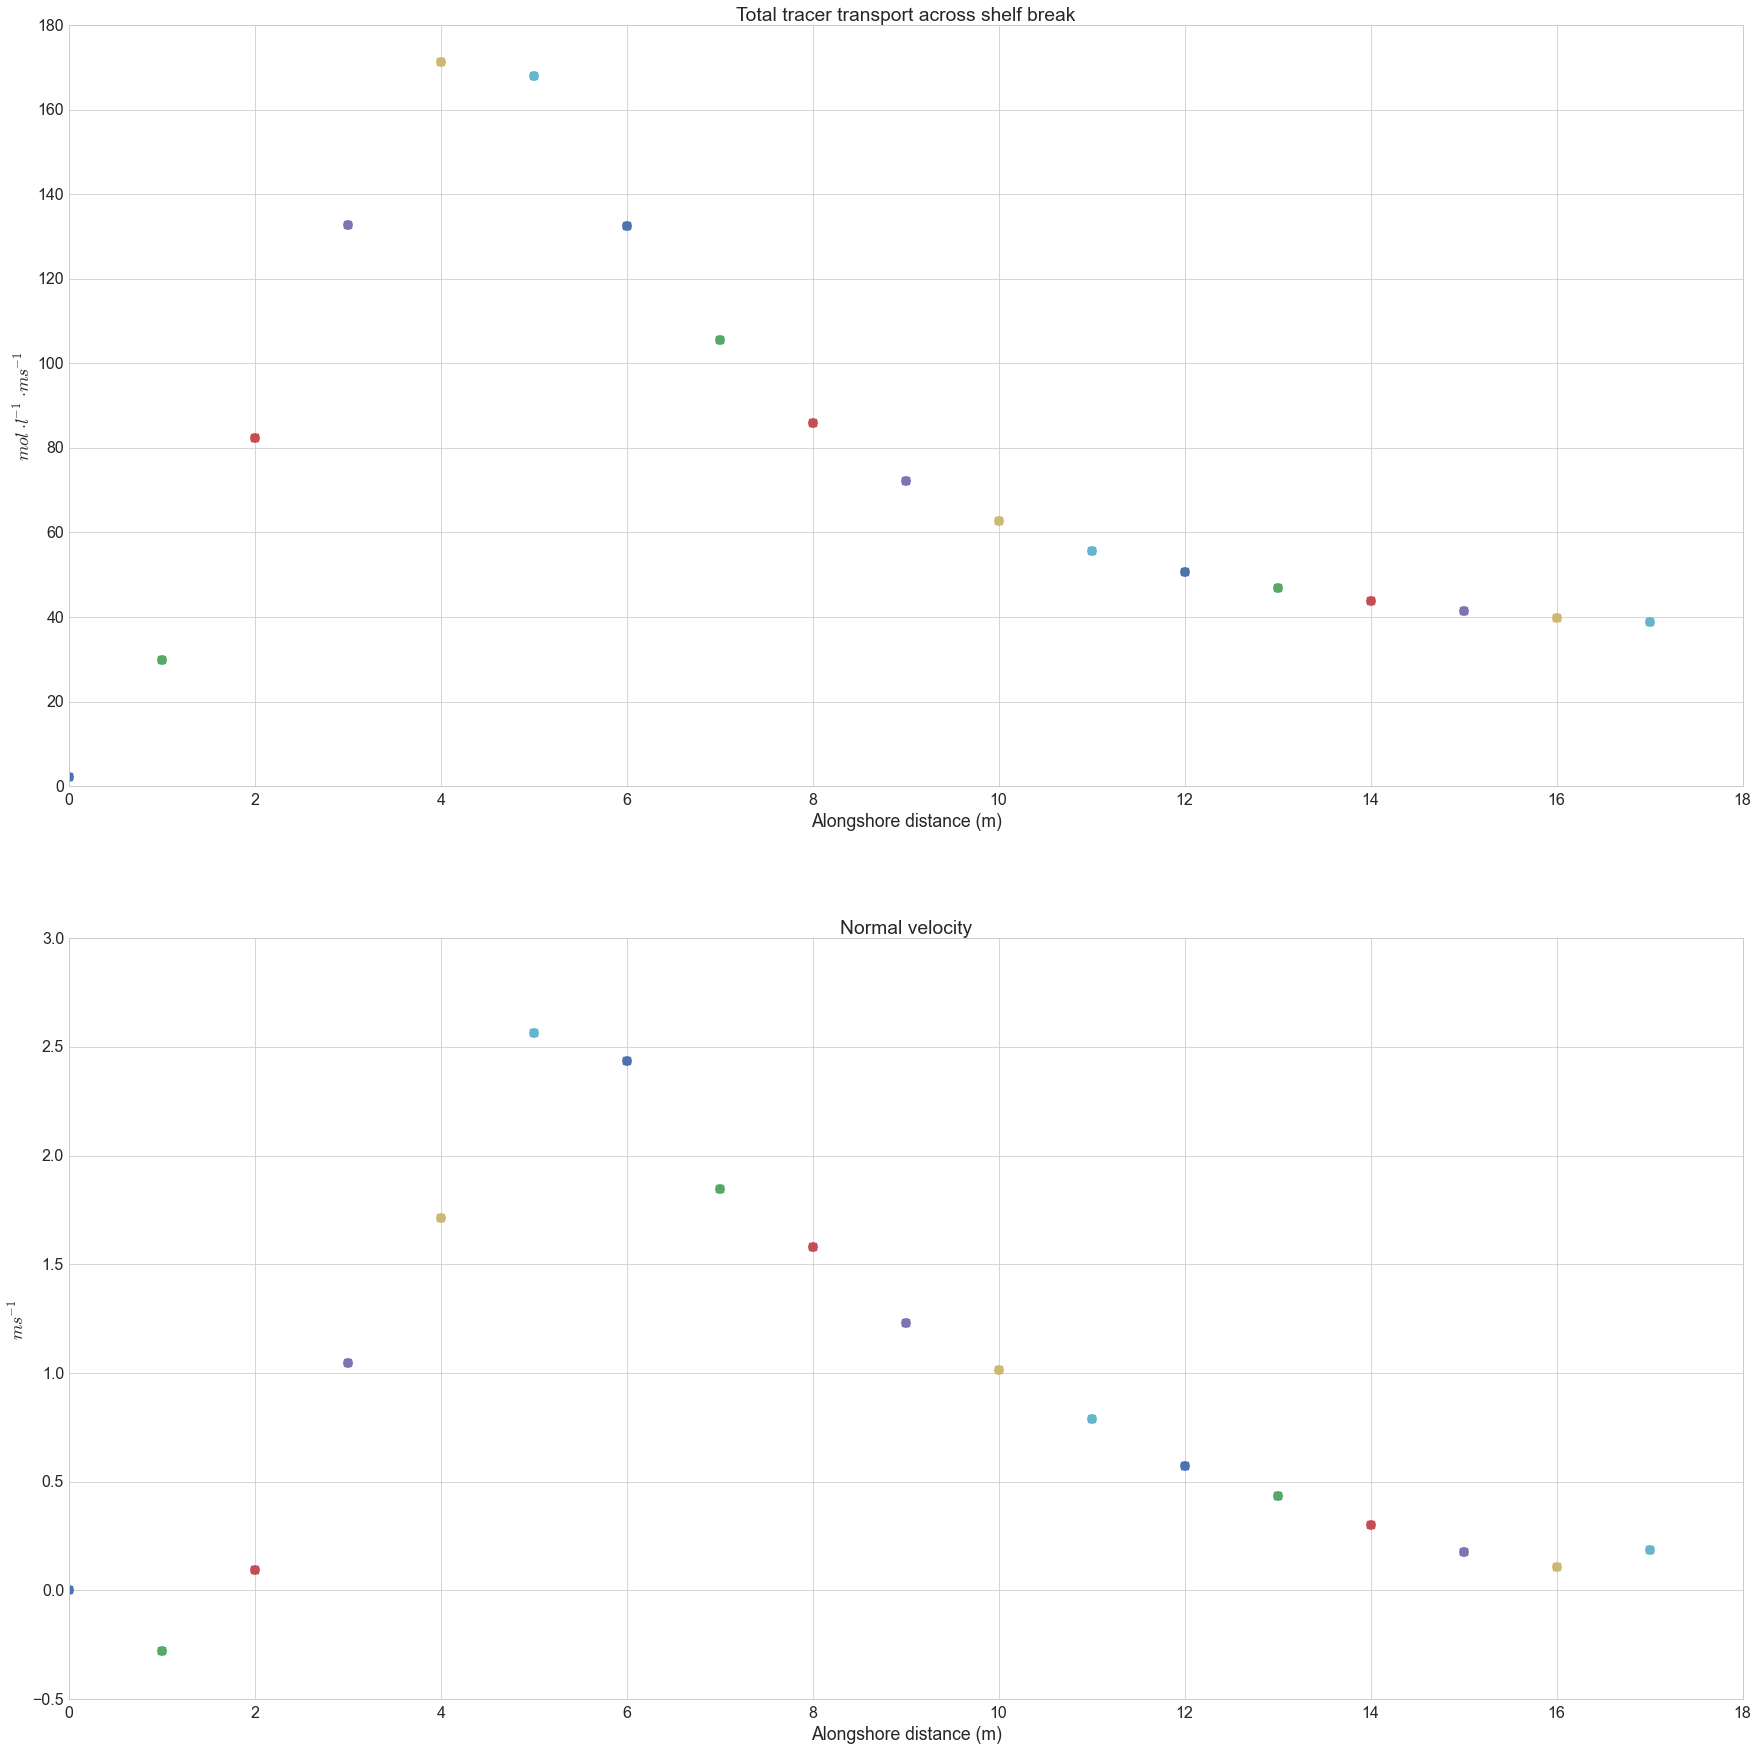

In [16]:
sns.set(context='paper', style='whitegrid', font='sans-serif', font_scale=2, rc={"lines.linewidth": 2.5})
times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times2 = range(18)
figSize=(30,30)
numCols = 1
numRows = 2
zlev = 29
unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'
unitsVel = '$ms^{-1}$'

kk=1

fig44 = plt.figure(figsize=figSize)

for tt in times:
    VTRACPlot = sb.MerFluxSB(SBxxNoC,SByyNoC,tt,VTRAC01NoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    UTRACPlot = sb.ZonFluxSB(SBxxNoC,SByyNoC,tt,UTRAC01NoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    TracTrans =  VTRACPlot[:,4:-5]*np.cos(thetaFiltNoC) + UTRACPlot[:,4:-4]*np.sin(-thetaFiltNoC) 
    plt.subplot(numRows,numCols,1)
    ax = plt.gca()
    ax.plot(tt,np.sum(TracTrans),'o',markersize = 10,label = (" %1.1f days " % ((tt/2.)+0.5)))
    #plt.legend(loc=0)
    plt.xlabel('Alongshore distance (m)')
    plt.ylabel(unitsTr)
    plt.title('Total tracer transport across shelf break')
    
    VPlot = sb.MerFluxSB(SBxxNoC,SByyNoC,tt,VNoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    UPlot = sb.ZonFluxSB(SBxxNoC,SByyNoC,tt,UNoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    NormalVel =  VPlot[:,4:-5]*np.cos(thetaFilt) + UPlot[:,4:-4]*np.sin(-thetaFilt) 
    plt.subplot(numRows,numCols,2)
    ax = plt.gca()
    ax.plot(tt,np.sum(NormalVel),'o',markersize = 10,
            
            
            label = (" %1.1f days " % ((tt/2.)+0.5)))
    #plt.legend(loc=0)
    plt.xlabel('Alongshore distance (m)')
    plt.ylabel(unitsVel)
    plt.title('Normal velocity')

### Grid experiments

In [19]:
CanyonGrid1='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run03/gridGlob.nc'
CanyonGridOut1 = Dataset(CanyonGrid1)

CanyonState1='/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run03/stateGlob.nc'
CanyonStateOut1 = Dataset(CanyonState1)

FluxTR01_1 = '/ocean/kramosmu/MITgcm/CanyonUpwelling/360x360x90_3Tr_LinProfiles_BarkleyHyd_GMREDI_FluxDiagnostics/run03/FluxTR01Glob.nc'


In [20]:
z = CanyonStateOut1.variables['Z']
#print(z[10])

xc = rout.getField(CanyonGrid1, 'XC') # x coords tracer cells

yc = rout.getField(CanyonGrid1, 'YC') # y coords tracer cells

bathy = rout.getField(CanyonGrid1, 'Depth')

hFacC = rout.getField(CanyonGrid1, 'HFacC')
MaskC = rout.getMask(CanyonGrid1, 'HFacC')




In [21]:
V = rout.getField(CanyonState1,'V') # 
VTRAC01 = rout.getField(FluxTR01_1,'VTRAC01') # 

U = rout.getField(CanyonState1,'U') # 
UTRAC01 = rout.getField(FluxTR01_1,'UTRAC01') # 


In [22]:
zlev = 29
SBx, SBy = sb.findShelfBreak(zlev,hFacC)
SBxx = SBx[:-1]
SByy = SBy[:-1]
slope, theta = sb.findSlope(xc,yc,SBxx,SByy)
slopeFilt = sg.savitzky_golay(slope, 11, 3) # window size 11, polynomial order 3
thetaFilt = np.arctan(slopeFilt)


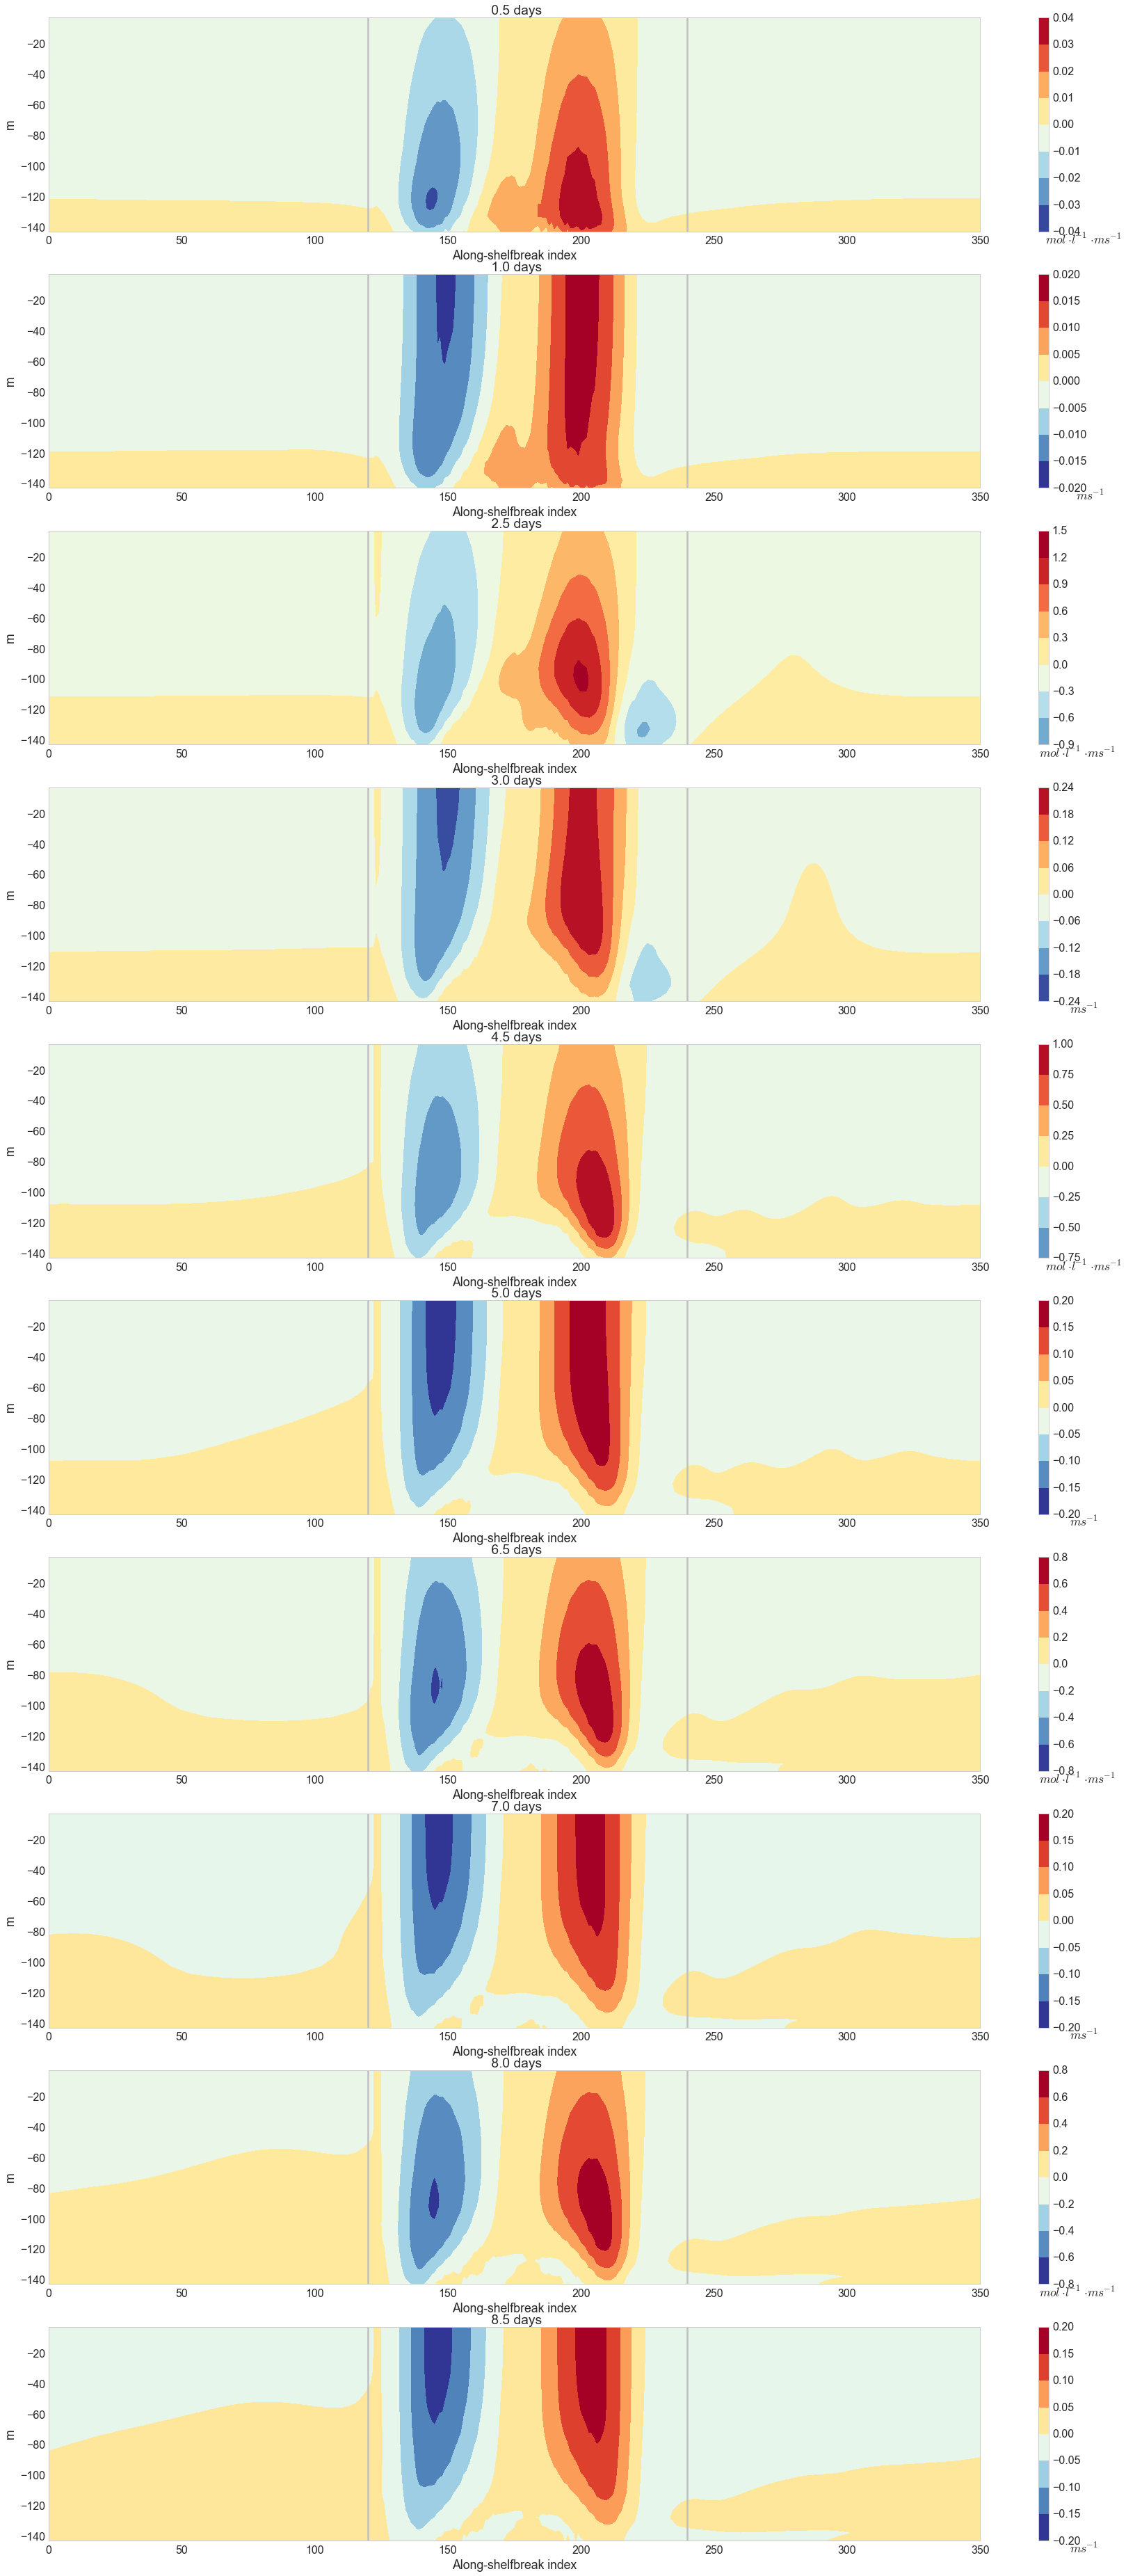

In [23]:
times = [0,4,8,12,15] # First time element of flux is at 43200 sec, and las at 8 days 
times2 = [1,5,9,13,16]
figSize=(30,65)
numCols = 1
numRows = 10
zlev = 29
unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'
unitsVel = '$ms^{-1}$'

kk=1

fig44 = plt.figure(figsize=figSize)

for tt in zip(times,times2):
    
    VTRACPlot = sb.MerFluxSB(SBxx,SByy,tt[0],VTRAC01,z,xc,zlev,hFacC,MaskC)
    UTRACPlot = sb.ZonFluxSB(SBxx,SByy,tt[0],UTRAC01,z,xc,zlev,hFacC,MaskC)
    
    VPlot = sb.MerFluxSB(SBxx,SByy,tt[1],V,z,xc,zlev,hFacC,MaskC)
    UPlot = sb.ZonFluxSB(SBxx,SByy,tt[1],U,z,xc,zlev,hFacC,MaskC)
    
    TracTrans =  VTRACPlot[:,4:-5]*np.cos(thetaFilt) + UTRACPlot[:,4:-4]*np.sin(-thetaFilt) 
    NormalVel =  VPlot[:,4:-5]*np.cos(thetaFilt) + UPlot[:,4:-4]*np.sin(-thetaFilt) 

    sb.contourfFluxSB(tt[0],numCols,numRows,TracTrans,z,xc,unitsTr, 0,29,kk,zlev)
    sb.contourfFluxSB(tt[1],numCols,numRows,NormalVel,z,xc,unitsVel, 0,29,kk+1,zlev)
    
    kk = kk+2

    

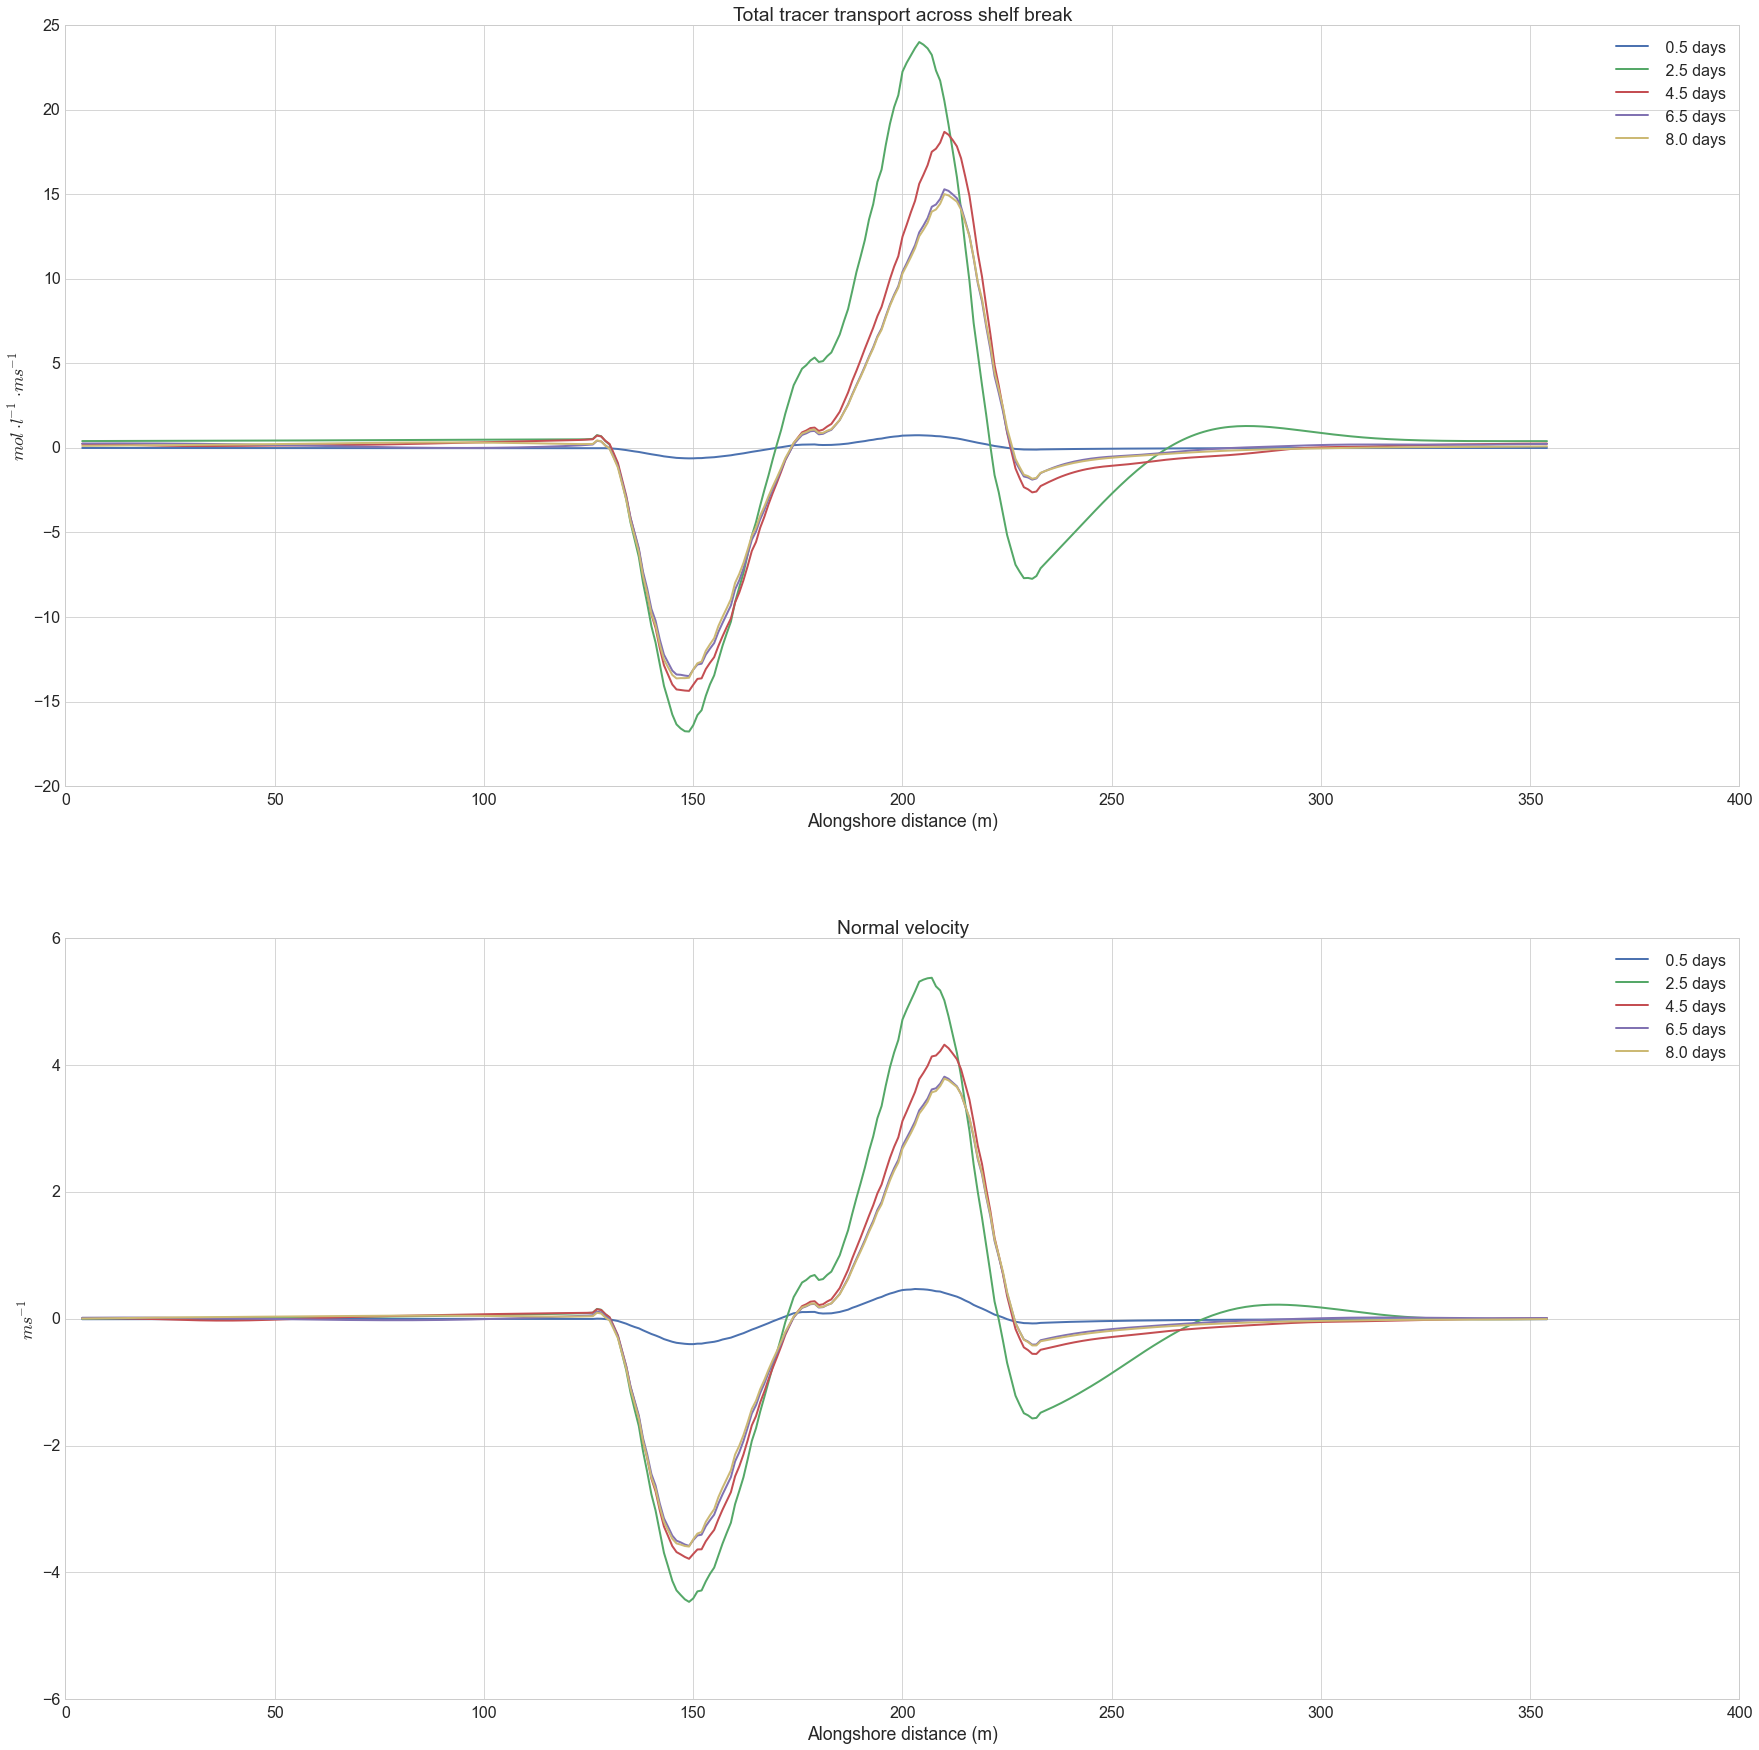

In [24]:
sns.set(context='paper', style='whitegrid', font='sans-serif', font_scale=2, rc={"lines.linewidth": 2.5})
times = [0,4,8,12,15] # First time element of flux is at 43200 sec, and las at 8 days 
times2 = [1,5,9,13,16]
figSize=(30,30)
numCols = 1
numRows = 2
zlev = 29
unitsTr = '$mol \cdot l^{-1}\cdot ms^{-1}$'
unitsVel = '$ms^{-1}$'

kk=1

fig44 = plt.figure(figsize=figSize)

for tt in zip(times,times2):
    VTRACPlot = sb.MerFluxSB(SBxx,SByy,tt[0],VTRAC01,z,xc,zlev,hFacC,MaskC)
    UTRACPlot = sb.ZonFluxSB(SBxx,SByy,tt[0],UTRAC01,z,xc,zlev,hFacC,MaskC)
    TracTrans =  VTRACPlot[:,4:-5]*np.cos(thetaFilt) + UTRACPlot[:,4:-4]*np.sin(-thetaFilt) 
    plt.subplot(numRows,numCols,1)
    ax = plt.gca()
    ax.plot(np.arange(4,360-5,1),np.sum(TracTrans,axis=0),linewidth=2,label = (" %1.1f days " % ((tt[0]/2.)+0.5)))
    plt.legend(loc=0)
    plt.xlabel('Alongshore distance (m)')
    plt.ylabel(unitsTr)
    plt.title('Total tracer transport across shelf break')
    
    VPlot = sb.MerFluxSB(SBxx,SByy,tt[1],V,z,xc,zlev,hFacC,MaskC)
    UPlot = sb.ZonFluxSB(SBxx,SByy,tt[1],U,z,xc,zlev,hFacC,MaskC)
    NormalVel =  VPlot[:,4:-5]*np.cos(thetaFilt) + UPlot[:,4:-4]*np.sin(-thetaFilt) 
    plt.subplot(numRows,numCols,2)
    ax = plt.gca()
    ax.plot(np.arange(4,360-5,1),np.sum(NormalVel,axis=0),linewidth=2,label = (" %1.1f days " % ((tt[0]/2.)+0.5)))
    plt.legend(loc=0)
    plt.xlabel('Alongshore distance (m)')
    plt.ylabel(unitsVel)
    plt.title('Normal velocity')
    
    